In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ziggy.exact_gp_1d_derivatives import *
sns.set_context("paper")
sns.set(font_scale=1.15)

In [2]:
torch.manual_seed(42)

a more complex function

In [3]:
import torch.nn as nn

In [4]:
def make_two_dim_synthetic_function(weight_std=35, hidden_dim=10, seed=42):
    torch.manual_seed(seed)
    class TestFun(nn.Module):
        def __init__(self):
            super(TestFun, self).__init__()
            self.lin = nn.Linear(1, hidden_dim)
            self.out = nn.Linear(hidden_dim, 1)

            for p in self.lin.parameters():
                p.data.normal_(std=weight_std).double()
            for p in self.out.parameters():
                p.data.normal_(std=.2).double()

            self.sft_plus = nn.Softplus()

        def forward(self, x):
            h = torch.sin(self.lin(x))
            h = torch.tanh(h)
            out = self.out(h)
            return self.sft_plus(out)

    fun = TestFun()
    #fun.double()

    def fun_npy(x):
        return fun(torch.FloatTensor(x)).detach().numpy()

    return fun, fun_npy

In [5]:
func_complexity = 'simple'
weight_std, hidden_dim = {
    'simple': (9, 9), #(8, 8), #(10, 10),
    'medium': (35, 10),
    'hard'  : (40, 25),
  }[func_complexity]

In [6]:
torch.manual_seed(42)
ftrue_pt, ftrue = make_two_dim_synthetic_function(weight_std, hidden_dim)

In [7]:
def get_observations(x, fun):
    x = torch.tensor(x.clone().detach().numpy(), requires_grad=True)
    f = fun(x.unsqueeze(-1))
    for i in range(len(x)):
        f[i].backward(retain_graph=True)
    fprime = x.grad
    return f.detach(), fprime

In [8]:
kwargs = dict(xlo=-1, xhi=1)
xlo, xhi = kwargs.get("xlo", -1), kwargs.get("xhi", 1)
gridnum = kwargs.get("gridnum", 256)
xgrid = torch.linspace(xlo, xhi, gridnum)

In [9]:
fgrid, fprime_grid = get_observations(xgrid, ftrue_pt)

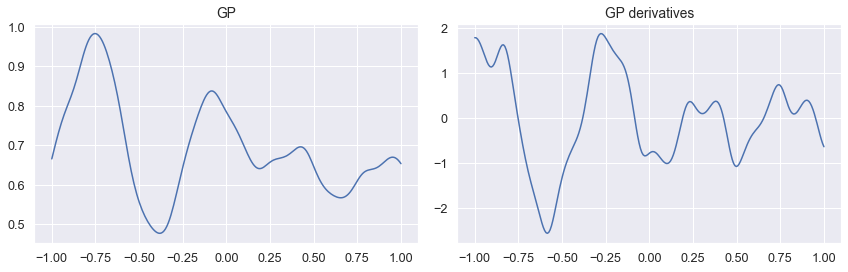

In [10]:
fig, axes = plt.subplots(1,2, figsize=(6*2, 4))
axes[0].plot(xgrid, fgrid)
axes[0].set_title("GP")

axes[1].plot(xgrid, fprime_grid)
axes[1].set_title("GP derivatives")

fig.tight_layout()

plt.savefig("/Users/leah/Columbia/2020Spring/dust-map/doc/HIP-GPs-2021/figures/derivative-synthetic/derivatives-obs.pdf")

In [11]:
# specify kernel hyper-parameters
sig2 = 0.5
ell = 0.1

Now we also add observations

In [12]:
# half observations, half derivative observations
nlatent = 100 
nprime = 20
xlatent, _ = torch.sort(torch.rand(nlatent) * 2-1)
xprime, _ = torch.sort(torch.rand(nprime) * 2 -1)

In [13]:
f = ftrue_pt(xlatent.unsqueeze(1))
f = f.detach()

In [14]:
"""
f_at_xprime = ftrue_pt(xprime.unsqueeze(1))
for i in range(nprime):
    f_at_xprime[i].backward(retain_graph=True)
fprime = xprime.grad
xprime = xprime.detach()
"""
f_at_xprime, fprime = get_observations(xprime, ftrue_pt)

In [15]:
# add observation noise 
# experimented with (0.05, 0.05), (0.05, 0.03), (0.05, 0.05), (0.05, 0.1), (0.05, 0.2)
obs_std = torch.tensor(0.05, dtype=torch.float)
derivative_std = torch.tensor(0.2, dtype=torch.float)
ylatent = f.squeeze() + torch.randn(nlatent) * obs_std
yprime = fprime + torch.randn(nprime) * derivative_std

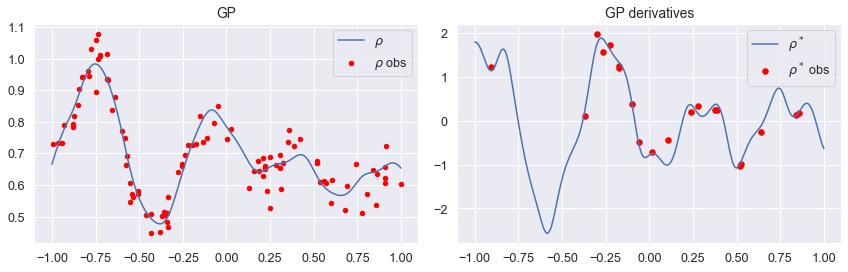

In [16]:
# plot observations
fig, axes = plt.subplots(1,2, figsize=(6*2, 4))
axes[0].plot(xgrid, fgrid, label=r'$\rho$')
axes[0].scatter(xlatent, ylatent, s=20, label=r'$\rho$ obs', color='red')
axes[0].set_title("GP")
axes[0].legend()

axes[1].plot(xgrid, fprime_grid, label=r'$\rho^*$')
axes[1].scatter(xprime, yprime, s=30, label=r'$\rho^*$ obs', color='red')
axes[1].set_title("GP derivatives")
axes[1].legend()

fig.tight_layout()

plt.savefig("/Users/leah/Columbia/2020Spring/dust-map/doc/HIP-GPs-2021/figures/derivative-synthetic/noisy-derivatives-obs.pdf")

hip-gp

In [17]:
M = 80
u = torch.linspace(-1, 1, M)

In [18]:
with torch.no_grad():
    m, S = svgp_batch_solve(u, xprime, yprime, xlatent, ylatent, sig2, ell, 
                                derivative_obs_noise_std=derivative_std, obs_noise_std=obs_std, 
                            whitened_type='ziggy', maxiter=20)

In [19]:
ntest = 100
xtest, _ = torch.sort(torch.rand(ntest) * 2-1)

In [20]:
ftest = ftrue_pt(xtest.unsqueeze(1)).detach()
ftest = ftest.squeeze()

In [21]:
fmu_test, fsig2_test = posterior_prediction(xtest, u, m, S, sig2, ell, domain='latent', batch_size=-1,
                                        whitened_type='ziggy', maxiter=20)

In [22]:
fmu_train, fsig2_train = posterior_prediction(xlatent, u, m, S, sig2, ell, domain='latent', batch_size=-1,
                                        whitened_type='ziggy', maxiter=20)

use svgp to solve

In [23]:
with torch.no_grad():
    m_svgp, S_svgp = svgp_batch_solve(u, xprime, yprime, xlatent, ylatent, sig2, ell, 
                                derivative_obs_noise_std=derivative_std, obs_noise_std=obs_std, 
                                whitened_type='cholesky')

In [24]:
fmu_test_svgp, fsig2_test_svgp = posterior_prediction(xtest, u, m_svgp, S_svgp, sig2, ell, domain='latent', batch_size=-1, 
                                             whitened_type='cholesky')

In [25]:
fsig_test_svgp = torch.sqrt(fsig2_test_svgp)

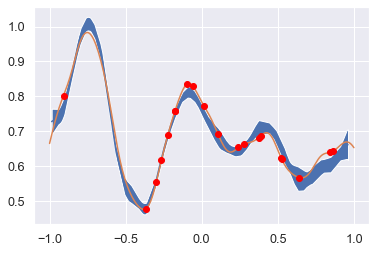

In [26]:
plt.plot(xtest, fmu_test_svgp)
plt.plot(xgrid, fgrid)
#plt.plot(xlatent, f)
plt.plot(xprime, f_at_xprime, 'o', color='red')
plt.fill_between(xtest, fmu_test_svgp + fsig_test_svgp, fmu_test_svgp - fsig_test_svgp)

use exact GP to solve

In [27]:
fmu_test_exact, fsig2_test_exact = exact_gp_prediction(xtest, xprime, yprime, xlatent, ylatent, sig2, ell, 
                    derivative_obs_noise_std=derivative_std, obs_noise_std=obs_std, batch_size=-1)

In [28]:
fsig_test_exact = torch.sqrt(fsig2_test_exact)

In [29]:
fmu_train_exact, fsig2_test_exact = exact_gp_prediction(xlatent, xprime, yprime, xlatent, ylatent, sig2, ell, 
                    derivative_obs_noise_std=derivative_std, obs_noise_std=obs_std, batch_size=-1)
fsig_train_exact = torch.sqrt(fsig2_test_exact.clamp_min(1e-5))

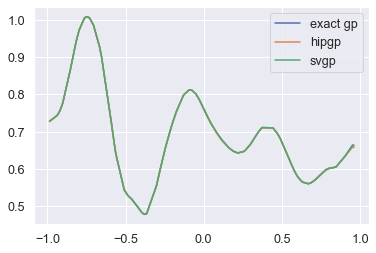

In [30]:
plt.plot(xtest, fmu_test_exact, label='exact gp')
plt.plot(xtest, fmu_test, label='hipgp')
plt.plot(xtest, fmu_test_svgp, label='svgp')

plt.legend()
#plt.plot(xprime, np.zeros_like(xprime)+0.006, 'o', color='red')

HIP GP without derivative observations

In [31]:
with torch.no_grad():
    m_2, S_2 = svgp_batch_solve(u, None, None, xlatent, ylatent, sig2, ell, 
                                derivative_obs_noise_std=derivative_std, obs_noise_std=obs_std, 
                            whitened_type='ziggy', maxiter=20)

In [32]:
fmu_test_2, fsig2_test_2 = posterior_prediction(xtest, u, m_2, S_2, sig2, ell, domain='latent', batch_size=-1,
                                        whitened_type='ziggy', maxiter=20)

In [33]:
fsig_test_2 = torch.sqrt(torch.clamp_min(fsig2_test_2, 1e-5))

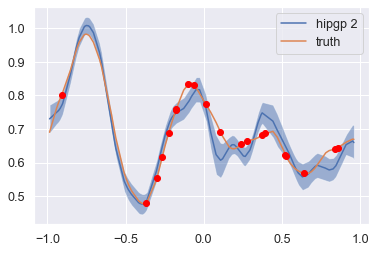

In [34]:
plt.plot(xtest, fmu_test_2, label='hipgp 2')
#plt.plot(xgrid, fgrid)
plt.plot(xtest, ftest, label='truth')
plt.plot(xprime, f_at_xprime, 'o', color='red')
#plt.plot(xlatent, f, 'o', color='orange')
plt.fill_between(xtest, fmu_test_2 + fsig_test_2, fmu_test_2 - fsig_test_2, alpha=0.5)
plt.legend()

In [39]:
fsig_test = torch.sqrt(fsig2_test)

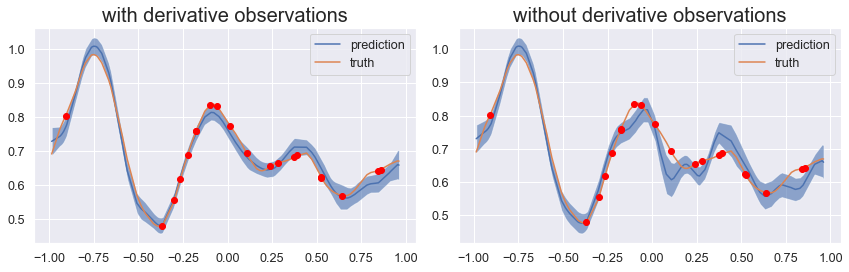

In [40]:
fig, axes = plt.subplots(1,2, figsize=(6*2, 4))

axes[0].plot(xtest, fmu_test, label='prediction')
axes[0].plot(xtest, ftest, label='truth')
axes[0].plot(xprime, f_at_xprime, 'o', color='red')
axes[0].fill_between(xtest, fmu_test + fsig_test, fmu_test - fsig_test, alpha=0.6)
axes[0].set_title("with derivative observations", fontsize=20)
axes[0].legend()

axes[1].plot(xtest, fmu_test_2, label='prediction')
axes[1].plot(xtest, ftest, label='truth')
axes[1].plot(xprime, f_at_xprime, 'o', color='red')
#plt.plot(xlatent, f, 'o', color='orange')
axes[1].fill_between(xtest, fmu_test_2 + fsig_test_2, fmu_test_2 - fsig_test_2, alpha=0.6)
axes[1].set_title("without derivative observations", fontsize=20)
axes[1].legend()

fig.tight_layout()

plt.savefig("./derivative-comparison.pdf")

exact gp without derivative observations

In [41]:
fmu_test_exact_2, fsig2_test_exact_2 = exact_gp_prediction(xtest, None, None, xlatent, ylatent, sig2, ell, 
                    derivative_obs_noise_std=derivative_std, obs_noise_std=obs_std, batch_size=-1)

In [42]:
fsig_test_exact_2 = torch.sqrt(fsig2_test_exact_2)

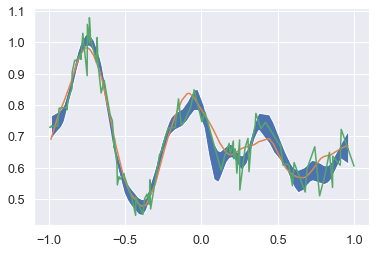

In [43]:
plt.plot(xtest, fmu_test_exact_2)
plt.plot(xtest, ftest)
plt.fill_between(xtest, fmu_test_exact_2 + fsig_test_exact_2, fmu_test_exact_2 - fsig_test_exact_2)
#plt.plot(xprime, f_at_xprime, 'o', color='red')
plt.plot(xlatent, ylatent)
#plt.plot(xtest, fmu_test)